# Análise de sentimentos dos headlines do Reddit
> O objetivo do notebook é montar um script capaz de extrair posts do reddit e a partir dele analizar o "sentimento" da frase.

> Importando as bibliotecas necessárias.

In [83]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
from googletrans import Translator
import praw
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/lucasmartins/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


> Instanciando os modelos usados.
* Para análise de sentimento será usado o Vader.
* Para a tradução de posts onde o idioma não é ingles, iremos usar o google translate para traduzir para inglês.

In [46]:
vader_model = SentimentIntensityAnalyzer()
translate_model = Translator()

> CLIENT_ID, SECRET_KEY e USER, são as "chaves" da API, foram gerados a partir do Reddit para um script pessoal.
* subredt = Caso desejado, alterar de 'all' (todos os subreddit) para um subreddit específico.
* topic = É o tópico no qual se quer buscar.
* sort_topic = Ordenação do posts, pode ser por data, ordem de relevancia, mais novos... "all", "day", "hour", "month", "week", ou "year"
* search_limit = limite para quantidade de posts. `ATENÇÃO`: A depender do número escolhido (quanto maior) é possível que haja erros na fase de tradução pelo excesso de requests. (Buscando alternativas)

In [47]:
CLIENT_ID = '****'
SECRET_KEY = ''****''
USER = ''****''
subredt = 'all'
topic = '5G'
sort_topic = 'relevance'
search_limit = 250

Mais methodos em: https://praw.readthedocs.io/en/latest/code_overview/models/subreddit.html#praw.models.Subreddit.submissions

In [48]:
reddit = praw.Reddit(client_id=CLIENT_ID, client_secret=SECRET_KEY, user_agent=USER)

> criando um dicionário que terá como chave 'headline' e irá receber os headlines de acordo com os parametros escolhidos.

In [49]:
posts ={'headline': []}
for sub in reddit.subreddit(subredt).search(topic, sort=sort_topic, limit=search_limit):
    posts['headline'].append(sub.title)

> Fase de tradução, aqui foi criado um loop que percorre todos os posts, checa se a frase do headline está em inglês. Se estiver, segue. Se não, traduz a frase e substitui pela que estava. 

In [50]:
for i in range(search_limit):
    for key, value in posts.items():
        phrase = value[i]
        src = translate_model.detect(phrase).lang
        if src == 'en':
            continue
        else:
            posts[key][i] = translate_model.translate(phrase, src = src, dest='en').text

> Criando dataframe a partir do dict.

In [51]:
posts_df = pd.DataFrame.from_dict(posts)

> Criando as colunas de predição e compound. Aqui utilizamos o Vader para obter os scores de cada frase.

In [52]:
posts_df['scores'] = posts_df['headline'].apply(lambda headline: vader_model.polarity_scores(headline))
posts_df['neg'] = [vader_model.polarity_scores(x)['neg'] for x in posts_df.headline]
posts_df['neu'] = [vader_model.polarity_scores(x)['neu'] for x in posts_df.headline]
posts_df['pos'] = [vader_model.polarity_scores(x)['pos'] for x in posts_df.headline]
posts_df['compound']  = posts_df['scores'].apply(lambda score_dict: score_dict['compound'])
posts_df['comp_score'] = posts_df['compound'].apply(lambda compound: 'positivo' if compound>0.05 else 'negativo' if compound<-0.5 else 'neutro')

> Plotagem dos sentimentos a modo que fique mais gráfico.

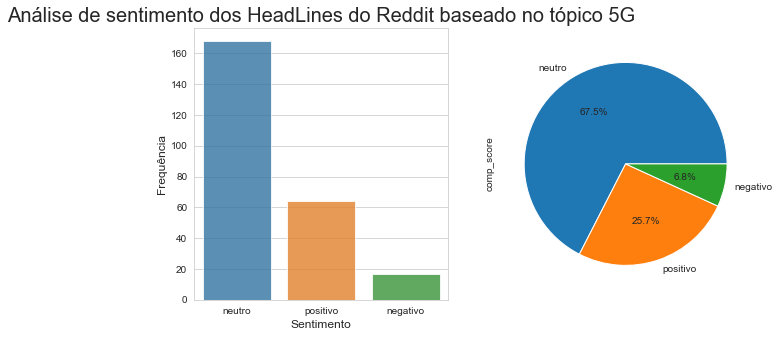

In [84]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize=(10,5))
sns.barplot(posts_df['comp_score'].value_counts().index, posts_df['comp_score'].value_counts().values, alpha=0.8, ax=axes[0])
axes[0].set_title(f'Análise de sentimento dos HeadLines do Reddit baseado no tópico {topic}', fontsize=20)
axes[0].set_ylabel('Frequência', fontsize=12)
axes[0].set_xlabel('Sentimento', fontsize=12)
posts_df['comp_score'].value_counts().plot.pie(autopct='%.1f%%',ax=axes[1]);

> Ordenando o dataframe para visualização, são mostrados apenas os valores em que o composição total do score é negativa.
* o [:posts_df.comp_score[posts_df.comp_score == 'negativo'].value_counts().sum()] garante que só serão plotados os dados negativos, pois retorna o número total de valores negativos presentes no dataframe.

In [54]:
posts_df.sort_values(by='compound', ascending=True)[:posts_df.comp_score[posts_df.comp_score == 'negativo'].value_counts().sum()]

,headline,scores,neg,neu,pos,compound,comp_score
212,i’m an Australian noob… this is what i’m looki...,"{'neg': 0.17, 'neu': 0.83, 'pos': 0.0, 'compou...",0.170,0.830,0.000,-0.8957,negativo
164,"Canada to ban Huawei and ZTE from 5G network, ...","{'neg': 0.489, 'neu': 0.511, 'pos': 0.0, 'comp...",0.489,0.511,0.000,-0.8225,negativo
1,I’m on 5.5G rn this shit crazy,"{'neg': 0.571, 'neu': 0.429, 'pos': 0.0, 'comp...",0.571,0.429,0.000,-0.7684,negativo
4,Hundreds of dead bees litter the ground around...,"{'neg': 0.314, 'neu': 0.686, 'pos': 0.0, 'comp...",0.314,0.686,0.000,-0.7506,negativo
70,Hundreds of dead bees litter the ground around...,"{'neg': 0.314, 'neu': 0.686, 'pos': 0.0, 'comp...",0.314,0.686,0.000,-0.7506,negativo
77,Decision to ban Huawei and ZTE from 5G wasn't ...,"{'neg': 0.353, 'neu': 0.647, 'pos': 0.0, 'comp...",0.353,0.647,0.000,-0.7189,negativo
23,Girlfriend in bad spot after 5g penis envy trip.,"{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'comp...",0.444,0.556,0.000,-0.6808,negativo
112,how the hell can you shut off 5g on T-Mobile s...,"{'neg': 0.195, 'neu': 0.805, 'pos': 0.0, 'comp...",0.195,0.805,0.000,-0.6808,negativo
19,Man Verizon's 5g is JUST AWFUL!!,"{'neg': 0.463, 'neu': 0.537, 'pos': 0.0, 'comp...",0.463,0.537,0.000,-0.6505,negativo
173,Who could have predicted that? 5G no longer a ...,"{'neg': 0.282, 'neu': 0.718, 'pos': 0.0, 'comp...",0.282,0.718,0.000,-0.6249,negativo


> Criando varivável que irá armazenar todas as frases negativas.

In [75]:
for col, row in posts_df.sort_values(by='compound', ascending=True)[:posts_df.comp_score[posts_df.comp_score == 'negativo'].value_counts().sum()].iteritems():
    if col == 'headline':
        negative_phrases = row.values

negative_phrases

array(['i’m an Australian noob… this is what i’m looking at using. halving it with my gf will give us both a 375mg dose of dxm but will also give us a 2.5g dose of guaifenesin. just wondering if that kind of dose of guaifenesin will have any negative effects or fatal effects?',
       'Canada to ban Huawei and ZTE from 5G network, risking China tensions',
       'I’m on 5.5G rn this shit crazy',
       'Hundreds of dead bees litter the ground around 5G towers disguised as palm trees in California',
       'Hundreds of dead bees litter the ground around 5G towers disguised as palm trees in California',
       "Decision to ban Huawei and ZTE from 5G wasn't easy, PM Trudeau says",
       'Girlfriend in bad spot after 5g penis envy trip.',
       "how the hell can you shut off 5g on T-Mobile s21 ultra? video for reference on what I'm dealing with.",
       "Man Verizon's 5g is JUST AWFUL!!",
       'Who could have predicted that? 5G no longer a big deal, time to worry about *6G*',
       '

> Criando função de display das palavras que mais apareceram em cada lista de frases fornecidas.
* São mostradas as palavras que mais apareceram quando o score foi negativo ou positivo. Assim como de todo conjunto de dados.

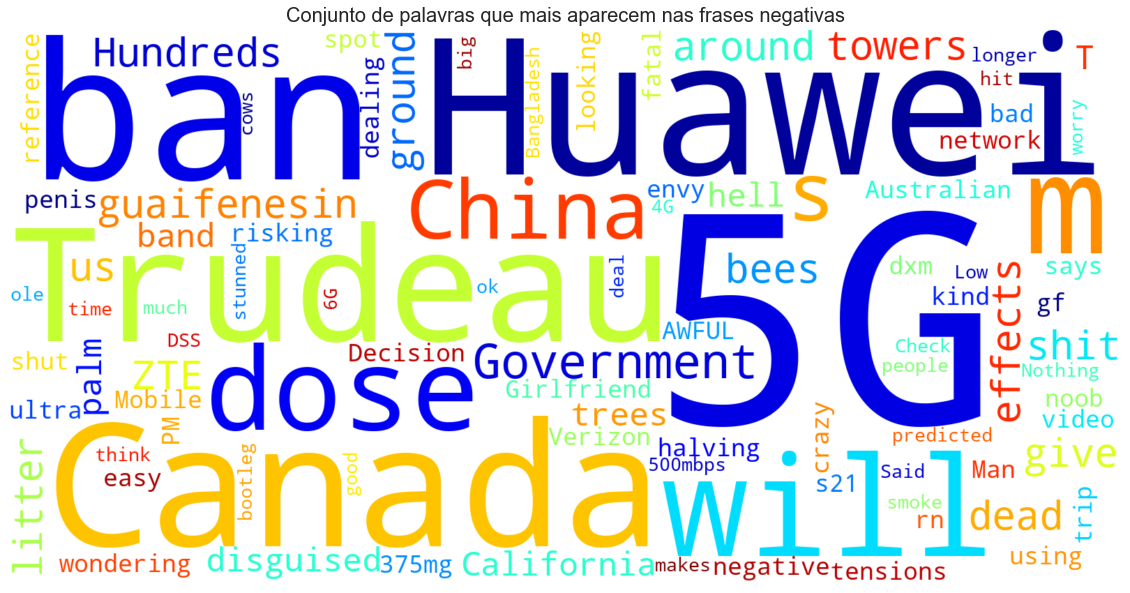

In [91]:
def word_cloud(wd_list, title):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=42,
        colormap='jet',
        max_words=100).generate(all_words)

    plt.figure(figsize=(20, 15))
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(negative_phrases, 'Conjunto de palavras que mais aparecem nas frases negativas')

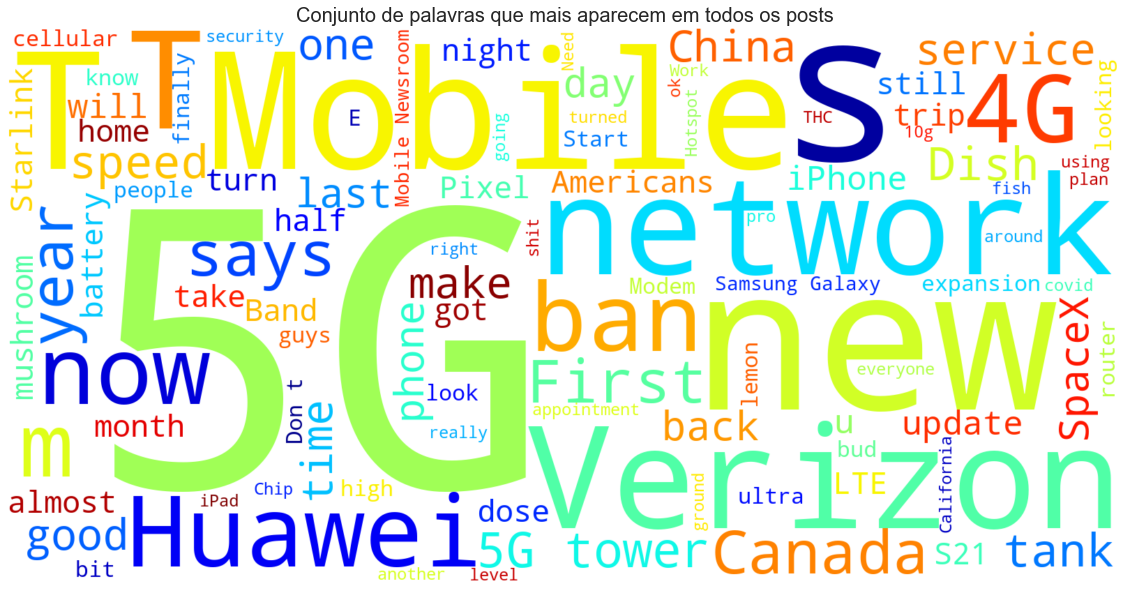

In [92]:
word_cloud(posts_df.headline, 'Conjunto de palavras que mais aparecem em todos os posts')

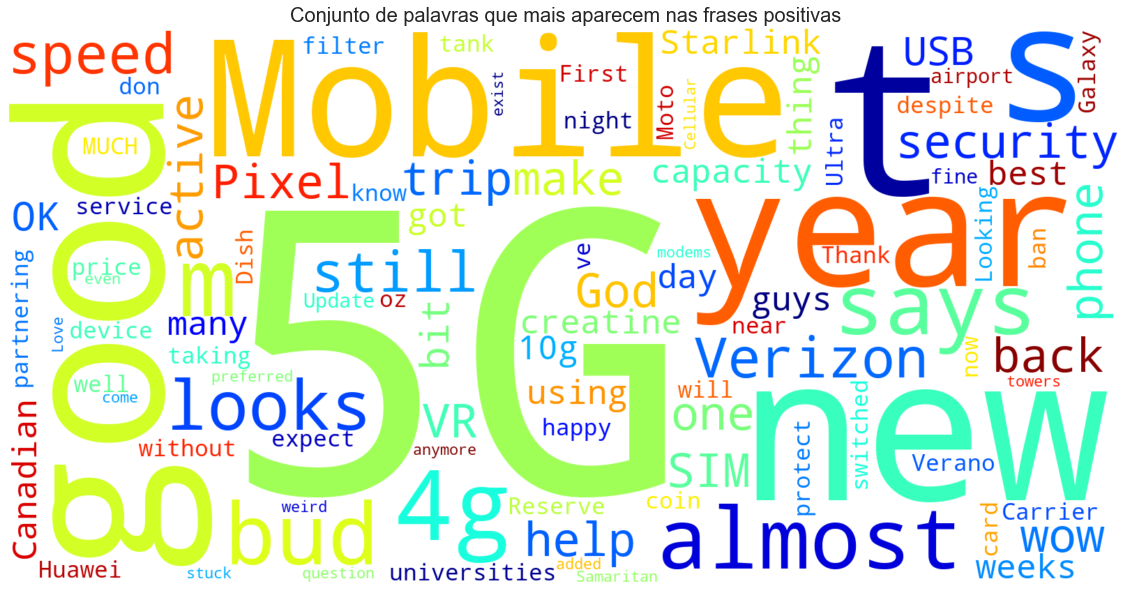

In [93]:
word_cloud(posts_df.headline[posts_df.comp_score == 'positivo'], 'Conjunto de palavras que mais aparecem nas frases positivas')